This is an [jupyter](http://jupyter.org) notebook.
Lectures about Python, useful both for beginners and experts, can be found at http://scipy-lectures.github.io.

# <font color= 'blue'> Poisson Image Editing</font>

## Seamless Image Cloning

***
 A notebook by ***Dhruv Ilesh Shah***
***

In this exercise, we will learn and implement Seamless Image Cloning by employing the Poisson Solver.

***Packages Used: *** Python 2.7 *(along with Numpy and Matplotlib)*, openCV 3.1.0, `gimp 2.8` (recommended)
***
***

### Motivation

Image cloning and morphing have been some of the most common purposes of Image Processing and editing. Most of us have used these tools at a very abstract level through packages like Photoshop or GIMP etc. But have you ever thought about what goes into actuating this process? Here we explain the math behind the idea and the algorithm for seamlessly cloning an image *(or a portion thereof)* onto another image.

Soon after, we'll get our hands dirty by actually coding the algorithm and running it on a sample image to achieve the results for oursef. Towards the end, we will also look at the various parameters that can be tweaked to achieve better results.

### Understanding Seamless Cloning

Say you want to morph a portion of image 1 onto a position on image 2. The simplest way to start off is to simply **paste** that portion of image on the other. But well, as you'd expect, the border has a very *sharp* change in features (known as gradient) and hence we can easily claim that the image is forged. What we need is a way to create a softer gradient, so that the image looks more natural.
![Seamless Cloning Example](seamless_cloning_ex.jpg)

As you see above, the softening of edges can be employed to make the image look better. This is a common blendng style in many Image Editing tools. Our goal, in this notebook, is to implement a function that can do a similar task from scratch. *(Do note that a similar function already exists in openCV)*

In [3]:
%matplotlib inline 

import cv2
import numpy as np
import matplotlib.pyplot as plt

For applying the algorithm, you will need the cloned image and a mask that identifies the cloned portion of the image. The purpose of the mask will clear in the subsequent steps.  
***How to obtain the mask?*** *This method needs improvement - suggestions welcome!*
* Given that you clone the image on your system, I recommend you use `gimp` for the purpose. Open `GIMP Image Editor`.
* Open the image on which cloning must occur, the destination image.
* In another window, open the source, whose portion is to be cloned. Using the select tool, select and copy the portion.
* Paste the portion on the destination image. You will see that a new layer with the pasted portion will be created. Using the `Transform` tool, move the portion to desired location and scale accordingly, using the `Scale` tool.
* Export this image and save your cloned file as a `jpeg` or `png` file. Now we must make the mask.
* Create a new `background layer` and place it below the pasted layer. Also, hide the destination image layer. Select the bg-layer and color it black using the Color Tool.
* You will now have the cloned portion on a black background. Using the Thresholding tool (or on `cv2`), threshold all pixels above 1 as 255.(*This should work unless your image has a pixel value 0, in which case you may have to use floodFill or explicitly modify the mask file*).
* Export this file as the mask image in the `jpeg` or `png` format.

Let's now begin with the algorithm implementation.

In [4]:
im_cloned = cv2.imread("stinkbug_cloned.png",  cv2.IMREAD_GRAYSCALE)
im_mask = cv2.imread("stinkbug_cloned_mask.png", cv2.IMREAD_GRAYSCALE)
it = 50; # Set number of iterations

After importing the image and mask, we create a temporary image to store the current value of pixels as the new ones are being calculated. This is because we want to simultaneously update values. * The iterative method used is called the ** Jacobi's Method. ** *

In [ ]:
im_temp = im_cloned.copy()
im_seamless = im_temp.copy()
sigma = []
for i in range(im_cloned.shape[0]):
        for j in range(im_cloned.shape[1]):
            if (im_mask[i,j]==255):
                sigma.append([i,j])

for a in range(it):
    for [i,j] in sigma:
        term = 10000
        term = term + im_seamless[i+1, j]+im_seamless[i-1, j]+im_seamless[i, j-1]+im_seamless[i, j+1]
        if(im_mask[i-1, j]==255):
            term = term + im_cloned[i,j]-im_cloned[i-1,j]
        if(im_mask[i+1, j]==255):
            term = term + im_cloned[i,j]-im_cloned[i+1,j]
        if(im_mask[i, j+1]==255):
            term = term + im_cloned[i,j]-im_cloned[i,j+1]
        if(im_mask[i, j-1]==255):
            term = term + im_cloned[i,j]-im_cloned[i,j-1]
        im_temp[i,j] = (term-10000)/4
    im_seamless = im_temp.copy()
    print a

As is visible from the code, we scan the whole cloned image for points where the corresponding value of the mask is 255 (*white*), and update `im_temp` as suggested in the algorithm. The gradient for the source image is defined as zero at the boundary points.
*Note that the pixel values in cv2 are of `ubyte_scalar` type and hence don't support addition due to overflow. `10000` is a random large number that helps maintain the variable `term` as a normal integer and hence allow addition without overflow*

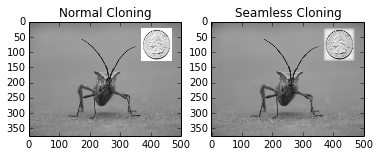

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_cloned,cmap = 'gray')
ax[0].set_title('Normal Cloning')
ax[1].imshow(im_seamless, cmap='gray')
ax[1].set_title('Seamless Cloning')

#### Thank You!